# Kaggle Spaceship Titanic

## Libraries

In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import GridSearchCV


## UDF

In [156]:
# Function to plot the ROC curve
def plot_roc(y_test, y_score,y_train, y_score_train):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    fpr_train = dict()
    tpr_train = dict()
    roc_auc_train = dict()
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

    # Compute micro-average ROC curve and ROC area
    fpr_train["micro"], tpr_train["micro"], _ = metrics.roc_curve(y_train.ravel(), y_score_train.ravel())
    roc_auc_train["micro"] = metrics.auc(fpr_train["micro"], tpr_train["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
             lw=lw, label='Test ROC curve (area = %0.2f)' % roc_auc["micro"])
    plt.plot(fpr_train["micro"], tpr_train["micro"], color='green',
             lw=lw, label='Training ROC curve (area = %0.2f)' % roc_auc_train["micro"])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

## File reading and basic variables analysis

We read the training file and print some rows to check how it looks

In [157]:
# Training file import and data frame display
df = pd.read_csv('/Users/pabloserranomolinero/Downloads/spaceship-titanic/train.csv')
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


We check columns types

In [158]:
# Columns types
df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

Now we will perform some basic statistics to do some quality checks

In [159]:
# Data frame description
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,8693,8693,1149_01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HomePlanet,8492,3,Earth,4602,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CryoSleep,8476,2,False,5439,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cabin,8494,6560,G/734/S,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Destination,8511,3,TRAPPIST-1e,5915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,8514.0,NaN,NaN,NaN,28.82793,14.489021,0.0,19.0,27.0,38.0,79.0
VIP,8490,2,False,8291,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RoomService,8512.0,NaN,NaN,NaN,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,NaN,NaN,NaN,458.077203,1611.48924,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,NaN,NaN,NaN,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0


In this descriptive statistics we don't see any wrong values such as negative ages or price of service. 

Let's check now the number of missing values we have in each variable.

In [160]:
# Data frame missing values
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

We see some missing values that we need to manage. At first, we will drop those values but further analysis may be needed to impute those missing values instead of deleting them.

In [161]:
#  Drop na values
df_na = df.dropna()
df_na.shape

(6606, 14)

We see that after cleaning na values we lost almost 2K obs in our dataset. We may look for some more optimal solution to this issue.

As a first simple approach to solve this we will fill missing values with the mode of the variable.

For the CryoSleep variable we will fill it as true if the money spent is zero.

In [162]:
# Fill na values
# We start by filling CryoSleep if money spent is 0
df.loc[(df['RoomService']  == 0) &
        (df['FoodCourt']    == 0)&
        (df['ShoppingMall'] == 0)&
        (df['Spa']          == 0)&
        (df['VRDeck']       == 0)&
        (df['CryoSleep'].isna()), 'CryoSleep'] = True

# We start by filling the missing values with the mode of the object columns
char_variables = list(df.select_dtypes(include=['object']).columns)

# We remove the columns that we do not want to fill since it doesnt make sense
char_variables.remove('Name')
char_variables.remove('Cabin')

for i in char_variables:
    df[i] = df[i].fillna(df[i].mode()[0])

For numeric variables we will first take a look to the distributions

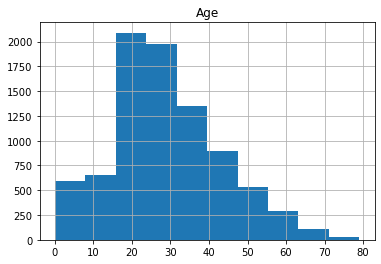

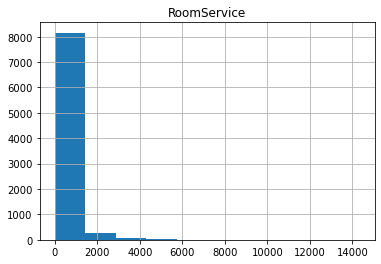

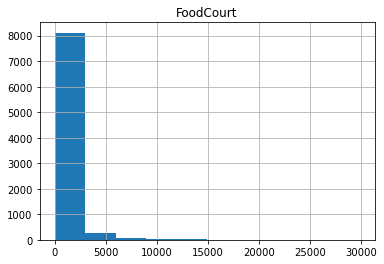

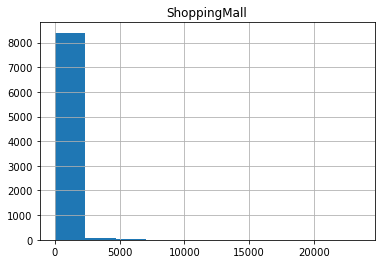

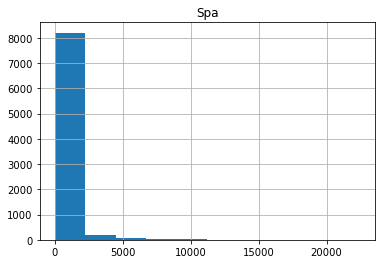

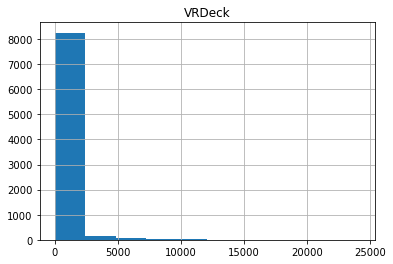

In [163]:
# We fill the missing values with the mean of the numeric columns
numeric_variables = list(df.select_dtypes(include=['int64', 'float64']).columns)

for col in numeric_variables:
    df.hist(column=col)

We can see that for the services variables mean doesn't make sense, since the distribution is very skewed. We will use the median for the na filling.

Similar to the case of CryoSleep variable we will now fill with 0 the money spent if the passenger is CryoSleep = True


In [164]:
# We first fill the money values based on the cryosleep values
df['RoomService'] = np.where(df['CryoSleep'] == True, 0, df['RoomService'])
df['FoodCourt'] = np.where(df['CryoSleep'] == True, 0, df['FoodCourt'])
df['ShoppingMall'] = np.where(df['CryoSleep'] == True, 0, df['ShoppingMall'])
df['Spa'] = np.where(df['CryoSleep'] == True, 0, df['Spa'])
df['VRDeck'] = np.where(df['CryoSleep'] == True, 0, df['VRDeck'])

for i in numeric_variables:
    df[i] = df[i].fillna(df[i].median())

## Feature engineering

In this step we will generate new features based on existing variables in our dataset.

In [165]:
# Based on the information we have, we can create new columns:

# New column with the passenger group
df['PassengerGroup'] = df['PassengerId'].str.slice(0, 4)

# New column with deck
df['Deck'] = df['Cabin'].str.split('/').str[0]

# New column with room number
df['Room'] = df['Cabin'].str.split('/').str[1]

# New column with side of the ship
df['Side'] = df['Cabin'].str.split('/').str[2]

# New colums to indicate if the passenger has a family member or not
df['HasFamily'] = df['PassengerGroup'].isin(df['PassengerGroup'].value_counts()[df['PassengerGroup'].value_counts() > 1].index).astype('bool')

# We create new variables with a boolean if passenger has spent money or not
df['BoolRoom'] = df['RoomService'].apply(lambda x: 1 if x > 0 else 0).astype('bool')
df['BoolFood'] = df['FoodCourt'].apply(lambda x: 1 if x > 0 else 0).astype('bool')
df['BoolMall'] = df['ShoppingMall'].apply(lambda x: 1 if x > 0 else 0).astype('bool')
df['BoolSpa'] = df['Spa'].apply(lambda x: 1 if x > 0 else 0).astype('bool')
df['BoolVRDeck'] = df['VRDeck'].apply(lambda x: 1 if x > 0 else 0).astype('bool')

# We create new variables with total money spent and average money spent
money_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df['TotalBill'] = df[money_cols].sum(axis = 1)
df['AverageBill'] = df[money_cols].mean(axis = 1)

# We create new variables with a boolean if passenger has spent money or not      
df['IsBill']    = df['TotalBill'] > 0
df['CountBill'] = df[money_cols].replace(0, np.nan, inplace=False).count(axis=1, numeric_only=True)


We delete some variables that we find irrelevant for our model. Also we generate the features and target dataframes for train/test split

In [166]:
# We create two new data frames, one with the features and the other with the target
Features = df.loc[:, df.columns.difference(['Transported', 'Name', 'Cabin','Room','PassengerGroup'])]
char_features = list(Features.select_dtypes(include=['object']).columns)
char_features.remove('PassengerId')
y = df['Transported']
Features

,Age,AverageBill,BoolFood,BoolMall,BoolRoom,BoolSpa,BoolVRDeck,CountBill,CryoSleep,Deck,...,HomePlanet,IsBill,PassengerId,RoomService,ShoppingMall,Side,Spa,TotalBill,VIP,VRDeck
0,39.0,0.0,False,False,False,False,False,0,False,B,...,Europa,False,0001_01,0.0,0.0,P,0.0,0.0,False,0.0
1,24.0,147.2,True,True,True,True,True,5,False,F,...,Earth,True,0002_01,109.0,25.0,S,549.0,736.0,False,44.0
2,58.0,2076.6,True,False,True,True,True,4,False,A,...,Europa,True,0003_01,43.0,0.0,S,6715.0,10383.0,True,49.0
3,33.0,1035.2,True,True,False,True,True,4,False,A,...,Europa,True,0003_02,0.0,371.0,S,3329.0,5176.0,False,193.0
4,16.0,218.2,True,True,True,True,True,5,False,F,...,Earth,True,0004_01,303.0,151.0,S,565.0,1091.0,False,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,1707.2,True,False,False,True,True,3,False,A,...,Europa,True,9276_01,0.0,0.0,P,1643.0,8536.0,True,74.0
8689,18.0,0.0,False,False,False,False,False,0,True,G,...,Earth,False,9278_01,0.0,0.0,S,0.0,0.0,False,0.0
8690,26.0,374.6,False,True,False,True,False,2,False,G,...,Earth,True,9279_01,0.0,1872.0,S,1.0,1873.0,False,0.0
8691,32.0,927.4,True,False,False,True,True,3,False,E,...,Europa,True,9280_01,0.0,0.0,S,353.0,4637.0,False,3235.0


We generate dummy variables for the categorical variables and split the data in train and test

In [167]:
# Generate binary values using get_dummies
dum_df = pd.get_dummies(Features[char_features], columns=char_features, prefix=['Deck_','Destination_','HomePlanet_','Side_'])
X = Features.join(dum_df)
X = X.drop(char_features, axis=1)

# We split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=4321)

We define a parameters grid to find the best model

In [168]:
%%time
# Parameters for the grid search
param_grid = {
    "loss":["deviance"],
    "learning_rate": np.linspace(0.4, 1, 15),
    "min_samples_split": np.linspace(0.01, 0.2, 15),
    "min_samples_leaf": [0.01],
    "max_depth":[8,10],
    "n_estimators":[11]
    }

# We fit a Gradient Boosting model with the train data
gbc = GradientBoostingClassifier()
grid_search = GridSearchCV(estimator = gbc, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 1, scoring='f1')
grid_search.fit(X_train, y_train)

# We predict the test data to check the accuracy
print('Champion model parameters : ',grid_search.best_params_)
print('Test Score : ',grid_search.score(X_test, y_test))
print('Train Score : ',grid_search.score(X_train, y_train))

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
Champion model parameters :  {'learning_rate': 0.5714285714285714, 'loss': 'deviance', 'max_depth': 10, 'min_samples_leaf': 0.01, 'min_samples_split': 0.17285714285714288, 'n_estimators': 11}
Test Score :  0.8140703517587939
Train Score :  0.8250070561670901
CPU times: user 8.39 s, sys: 1.53 s, total: 9.91 s
Wall time: 1min 19s


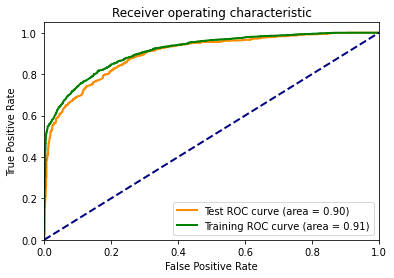

In [169]:
# We plot the ROC curve
plot_roc(y_test, grid_search.predict_proba(X_test)[:,1],y_train, grid_search.predict_proba(X_train)[:,1])

## Score the test dataset

Import the test file

In [170]:
# Test file import and data frame display
test = pd.read_csv('/Users/pabloserranomolinero/Downloads/spaceship-titanic/test.csv')
test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


We replicate the treatments done to the training frame

In [171]:
# Fill na values
# We start by filling CryoSleep if money spent is 0
test.loc[(test['RoomService']  == 0) &
        (test['FoodCourt']    == 0)&
        (test['ShoppingMall'] == 0)&
        (test['Spa']          == 0)&
        (test['VRDeck']       == 0)&
        (test['CryoSleep'].isna()), 'CryoSleep'] = True
        
# We start by filling the missing values with the mode of the object columns
char_variables = list(test.select_dtypes(include=['object']).columns)

# We remove the columns that we do not want to fill since it doesnt make sense
char_variables.remove('Name')
char_variables.remove('Cabin')

for i in char_variables:
    test[i] = test[i].fillna(test[i].mode()[0])

# We first fill the money values based on the cryosleep values
test['RoomService'] = np.where(test['CryoSleep'] == True, 0, test['RoomService'])
test['FoodCourt'] = np.where(test['CryoSleep'] == True, 0, test['FoodCourt'])
test['ShoppingMall'] = np.where(test['CryoSleep'] == True, 0, test['ShoppingMall'])
test['Spa'] = np.where(test['CryoSleep'] == True, 0, test['Spa'])
test['VRDeck'] = np.where(test['CryoSleep'] == True, 0, test['VRDeck'])

for i in numeric_variables:
    test[i] = test[i].fillna(test[i].median())


# Based on the information we have, we can create new columns:

# New column with the passenger group
test['PassengerGroup'] = test['PassengerId'].str.slice(0, 4)

# New column with deck
test['Deck'] = test['Cabin'].str.split('/').str[0]

# New column with room number
test['Room'] = test['Cabin'].str.split('/').str[1]

# New column with side of the ship
test['Side'] = test['Cabin'].str.split('/').str[2]

# New colums to indicate if the passenger has a family member or not
test['HasFamily'] = test['PassengerGroup'].isin(test['PassengerGroup'].value_counts()[test['PassengerGroup'].value_counts() > 1].index).astype('bool')

# We create new variables with a boolean if passenger has spent money or not
test['BoolRoom'] = test['RoomService'].apply(lambda x: 1 if x > 0 else 0).astype('bool')
test['BoolFood'] = test['FoodCourt'].apply(lambda x: 1 if x > 0 else 0).astype('bool')
test['BoolMall'] = test['ShoppingMall'].apply(lambda x: 1 if x > 0 else 0).astype('bool')
test['BoolSpa'] = test['Spa'].apply(lambda x: 1 if x > 0 else 0).astype('bool')
test['BoolVRDeck'] = test['VRDeck'].apply(lambda x: 1 if x > 0 else 0).astype('bool')

# We create new variables with total money spent and average money spent
money_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
test['TotalBill'] = test[money_cols].sum(axis = 1)
test['AverageBill'] = test[money_cols].mean(axis = 1)

# We create new variables with a boolean if passenger has spent money or not      
test['IsBill']    = test['TotalBill'] > 0
test['CountBill'] = test[money_cols].replace(0, np.nan, inplace=False).count(axis=1, numeric_only=True)

# We create a data frame with the features
Features = test.loc[:, test.columns.difference(['Transported', 'Name', 'Cabin','Room','PassengerGroup'])]
char_features = list(Features.select_dtypes(include=['object']).columns)
char_features.remove('PassengerId')

# Generate binary values using get_dummies
dum_test = pd.get_dummies(Features[char_features], columns=char_features, prefix=['Deck_','Destination_','HomePlanet_','Side_'])
X = Features.join(dum_test)
X = X.drop(char_features, axis=1)
X

,Age,AverageBill,BoolFood,BoolMall,BoolRoom,BoolSpa,BoolVRDeck,CountBill,CryoSleep,FoodCourt,...,Deck__G,Deck__T,Destination__55 Cancri e,Destination__PSO J318.5-22,Destination__TRAPPIST-1e,HomePlanet__Earth,HomePlanet__Europa,HomePlanet__Mars,Side__P,Side__S
0,27.0,0.0,False,False,False,False,False,0,True,0.0,...,1,0,0,0,1,1,0,0,0,1
1,19.0,566.4,True,False,False,True,False,2,False,9.0,...,0,0,0,0,1,1,0,0,0,1
2,31.0,0.0,False,False,False,False,False,0,True,0.0,...,0,0,1,0,0,0,1,0,0,1
3,38.0,1483.6,True,False,False,True,True,3,False,6652.0,...,0,0,0,0,1,0,1,0,0,1
4,20.0,129.0,False,True,True,False,False,2,False,0.0,...,0,0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,34.0,0.0,False,False,False,False,False,0,True,0.0,...,1,0,0,0,1,1,0,0,0,1
4273,42.0,203.6,True,True,False,True,True,4,False,847.0,...,0,0,0,0,1,1,0,0,0,0
4274,26.0,0.0,False,False,False,False,False,0,True,0.0,...,0,0,1,0,0,0,0,1,1,0
4275,26.0,640.6,True,False,False,False,True,2,False,2680.0,...,0,0,0,0,1,0,1,0,1,0


We now predict the test data and export the CSV for submission

In [172]:
# Generate the predictions
test['Transported'] = grid_search.predict(X)

In [173]:
# Check predictions frame
test[['PassengerId','Transported']]

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [174]:
# Export the predictions to a csv file
test[['PassengerId','Transported']].to_csv('/Users/pabloserranomolinero/Downloads/spaceship-titanic/submission_6.csv', index=False)